# Алгоритм Шора

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


# 1. Проблема: нахождение периода

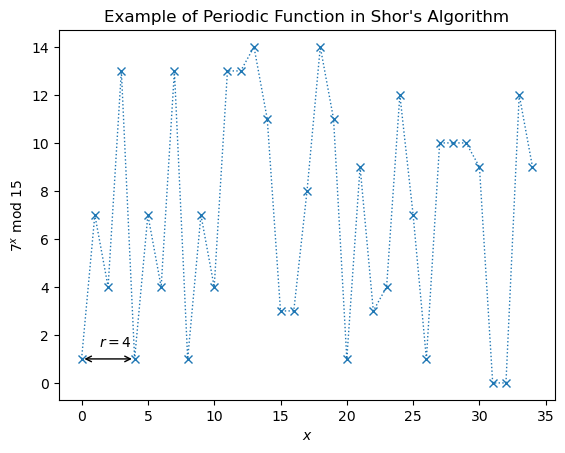

In [3]:
N = 15
a = 7

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

In [5]:
import pandas as pd

# Create a DataFrame from xvals and yvals
df = pd.DataFrame({'xvals': xvals, 'yvals': yvals})

# Display the DataFrame as a table
print(df.to_string(index=False))

 xvals  yvals
     0      1
     1      7
     2      4
     3     13
     4      1
     5      7
     6      4
     7     13
     8      1
     9      7
    10      4
    11     13
    12     13
    13     14
    14     11
    15      3
    16      3
    17      8
    18     14
    19     11
    20      1
    21      9
    22      3
    23      4
    24     12
    25      7
    26      1
    27     10
    28     10
    29     10
    30      9
    31      0
    32      0
    33     12
    34      9


# 2. Решение

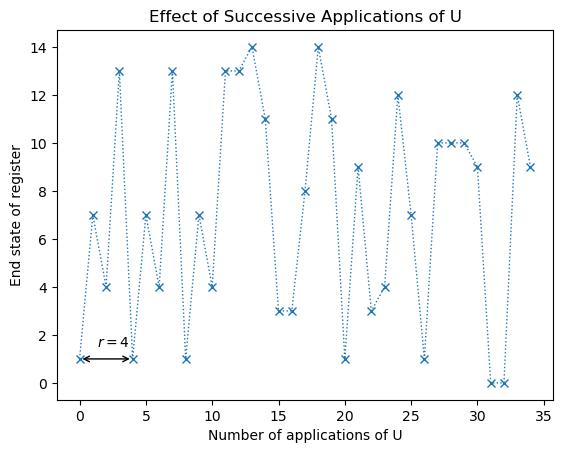

In [4]:
ax.set(xlabel='Number of applications of U',
       ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

# 3. Реализация Qiskit

In [5]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [6]:
# Specify variables
N_COUNT = 4  # number of counting qubits
a = 7

In [7]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [15]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q), [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                            ┌───────┐┌─┐         
q_0: ┤ H ├───────■────────────────────────────────────────────────────┤0      ├┤M├─────────
     ├───┤       │                                                    │       │└╥┘┌─┐      
q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────┤1      ├─╫─┤M├──────
     ├───┤       │              │                                     │  QFT† │ ║ └╥┘┌─┐   
q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────┤2      ├─╫──╫─┤M├───
     ├───┤       │              │              │                      │       │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────┤3      ├─╫──╫──╫─┤M├
     ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐└───────┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├──────────╫──╫──╫──╫─
     └───┘│             ││             ││             ││             │          ║  ║  ║  ║ 
q_5: ─────┤1            ├┤1            ├┤1            ├┤1            ├──────────╫──╫──╫──╫─
          │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │          ║  ║  ║  ║ 
q_6: ─────┤2            ├┤2            ├┤2            ├┤2            ├──────────╫──╫──╫──╫─
          │             ││             ││             ││             │          ║  ║  ║  ║ 
q_7: ─────┤3            ├┤3            ├┤3            ├┤3            ├──────────╫──╫──╫──╫─
          └─────────────┘└─────────────┘└─────────────┘└─────────────┘          ║  ║  ║  ║ 
c: 4/═══════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                0  1  2  3

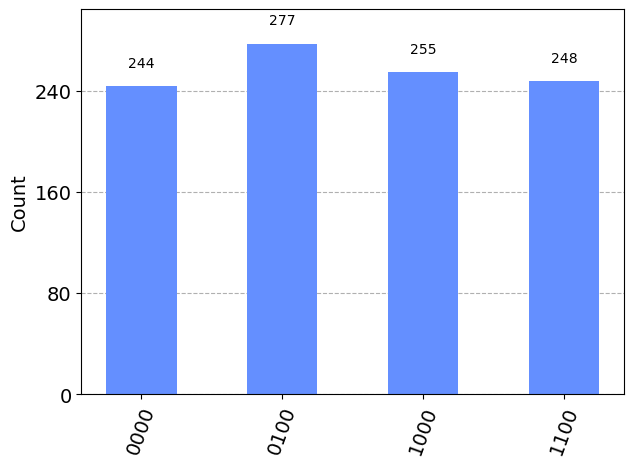

In [16]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [17]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

        Register Output         Phase
0  0100(bin) =   4(dec)   4/16 = 0.25
1  0000(bin) =   0(dec)   0/16 = 0.00
2  1000(bin) =   8(dec)   8/16 = 0.50
3  1100(bin) =  12(dec)  12/16 = 0.75


In [13]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [14]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [15]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.00      0/1            1
2   0.50      1/2            2
3   0.25      1/4            4


# 4. Модульное возведение в степень

In [16]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [17]:
a2jmodN(7, 2049, 53)

47

# 5. Разложение на множители на основе нахождения периода

In [18]:
N = 15

In [19]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


In [20]:
from math import gcd # greatest common divisor
gcd(a, N)

1

In [21]:
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

In [22]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)

Register Reading: 01000000
Corresponding Phase: 0.25


Fraction(1, 4)

In [23]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

4


In [24]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]


In [27]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 2:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 3:
Register Reading: 11000000
Corresponding Phase: 0.75
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


# 6. Список литературы

In [26]:
import qiskit.tools.jupyter
%qiskit_version_table